In [1]:
import re
import pandas as pd
from pathlib import Path
import spacy

nlp = spacy.load("en_core_web_sm")
nlp.max_length = 2000000

In [2]:
# Cleaning first part of text obtained from project guttenberg
def clean_guttenberg_header(text):
  ex = r"The Project Gutenberg eBook.*?\*\*\* START OF THE PROJECT GUTENBERG EBOOK.*?\*\*\*"
  main_text = re.sub(ex, "", text, flags=re.DOTALL)
  return main_text

# Cleaning out the footer extra info added by project gutteneberg
def clean_guttenberg_footer(text):
  ex = r"\*\*\* END OF THE PROJECT GUTENBERG EBOOK.*"
  main_text = re.sub(ex, "", text, flags=re.DOTALL)
  return main_text

def clean_guttenberg(text):
  clean = clean_guttenberg_header(text)
  clean = clean_guttenberg_footer(clean)
  return clean

In [3]:
data_dir = Path('./data')
 
corpus = {
    'Christie': [clean_guttenberg(p.read_text(encoding='utf-8-sig')) for p in (data_dir / 'ac').glob('*.txt')],
    'Chesterton':  [clean_guttenberg(p.read_text(encoding='utf-8-sig')) for p in (data_dir / 'gc').glob('*.txt')],
    'Shakespeare':  [clean_guttenberg(p.read_text(encoding='utf-8-sig')) for p in (data_dir / 'shakespeare').glob('*.txt')],
    'Leblanc':  [clean_guttenberg(p.read_text(encoding='utf-8-sig')) for p in (data_dir / 'ml').glob('*.txt')],
    'Doyle': [clean_guttenberg(p.read_text(encoding='utf-8-sig')) for p in (data_dir / 'cd').glob('*.txt')],
}

for author, works in corpus.items():
    print(f'{author}: {len(works)}')

Christie: 12
Chesterton: 26
Shakespeare: 4
Leblanc: 17
Doyle: 43


In [4]:
def sentence_chunk(text, chunk_size=100, overlap=50):
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents if len(sent.text.strip()) > 1]
    chunks = []
    for i in range(0, len(sentences), chunk_size - overlap):
        chunk = ' '.join(sentences[i:i + chunk_size])
        chunks.append(chunk)
    return chunks

In [5]:
chunk_size = 100
overlap = 0
dataset = {}
for author, works in corpus.items():
    dataset[author] = []
    for text in works:
        dataset[author].extend(sentence_chunk(text, chunk_size = chunk_size, overlap=overlap))

# Print the number of chunks for each list
for author, texts in dataset.items():
    print(f'{author}: {len(texts)} chunks')

Christie: 518 chunks
Chesterton: 698 chunks
Shakespeare: 110 chunks
Leblanc: 941 chunks
Doyle: 1473 chunks


In [6]:
def prepare_data(text):
  doc = nlp(text)
  normalized_tokens = []
  word_lengths= []
  sent_lengths= []

  for token in doc:
    if token.is_punct or token.is_space:
      continue
    token_text = token.text.strip().lower()
    normalized_tokens.append(token_text)
    word_lengths.append(len(token_text))
  normalized_text = ' '.join(normalized_tokens)

  sent_lengths=[len(sent) for sent in doc.sents]
  return normalized_text, word_lengths, sent_lengths

In [7]:
#Nomalize text, get word lengths and sentence lengths
wholeCorpus = ""
data_x = []
label_y = []
for author, works in dataset.items():
    for text in works:
        wholeCorpus += text
        normalized_text, word_lengths, sent_lengths = prepare_data(text)
        data_x.append(normalized_text)
        label_y.append(author)

#### Feature Engineering

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(stop_words='english')
bow_vectorizer.fit(data_x)

CountVectorizer(stop_words='english')

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_vectorizer.fit(data_x)

TfidfVectorizer(stop_words='english')

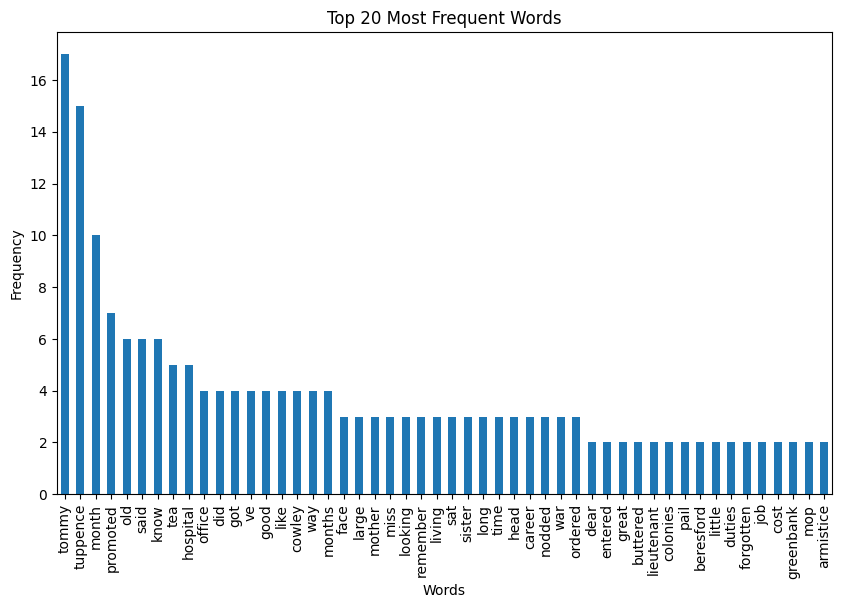

In [10]:
import matplotlib.pyplot as plt

bow_matrix = bow_vectorizer.transform([data_x[1]]) 
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=bow_vectorizer.get_feature_names_out())
bow_df.head()
word_counts = bow_df.sum(axis=0)
sorted_word_counts = word_counts.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sorted_word_counts.head(50).plot(kind='bar')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [11]:
from sklearn.preprocessing import OneHotEncoder
target_encoder = OneHotEncoder(sparse_output=False)
y = target_encoder.fit_transform(pd.DataFrame(label_y))

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

X = []

for item in data_x:
    X.append(bow_vectorizer.transform([item]).toarray().flatten())
     
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

              precision    recall  f1-score   support

  Chesterton       1.00      1.00      1.00       214
    Christie       1.00      0.93      0.96       174
       Doyle       1.00      0.98      0.99       420
     Leblanc       0.98      0.99      0.98       284
 Shakespeare       1.00      1.00      1.00        30

   micro avg       0.99      0.98      0.98      1122
   macro avg       0.99      0.98      0.99      1122
weighted avg       0.99      0.98      0.98      1122
 samples avg       0.97      0.98      0.98      1122



c:\Users\amiri\Documents\GitHub\nlp-524\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


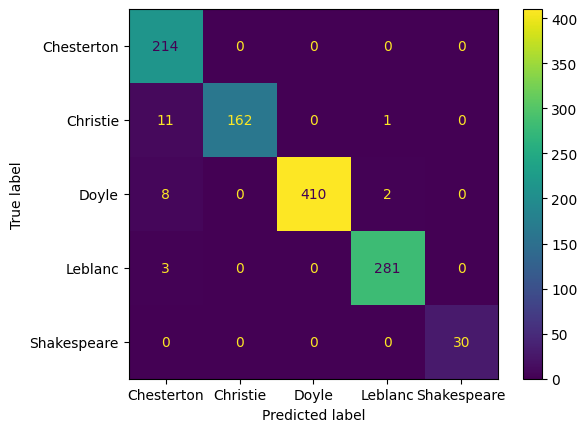

In [13]:
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(classification_report(y_test, pred, target_names=target_encoder.categories_[0]))
ConfusionMatrixDisplay.from_predictions(y_test.argmax(axis=1), pred.argmax(axis=1), display_labels=target_encoder.categories_[0])

              precision    recall  f1-score   support

  Chesterton       0.99      1.00      1.00       214
    Christie       1.00      0.97      0.98       174
       Doyle       1.00      0.99      0.99       420
     Leblanc       0.98      1.00      0.99       284
 Shakespeare       1.00      1.00      1.00        30

    accuracy                           0.99      1122
   macro avg       0.99      0.99      0.99      1122
weighted avg       0.99      0.99      0.99      1122



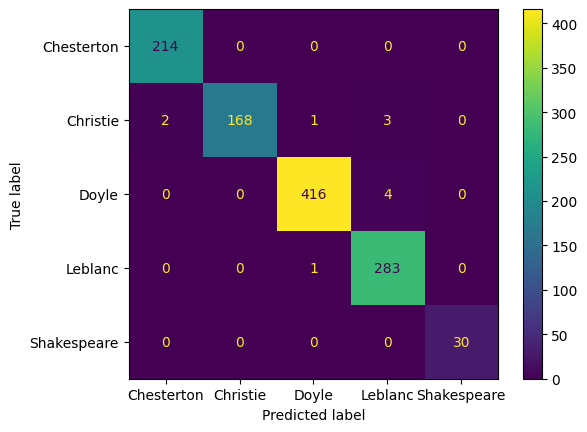

In [14]:
from sklearn.svm import SVC

svm_classifier = SVC(gamma='auto', kernel='linear')
svm_classifier.fit(X_train, y_train.argmax(axis=1))
pred = svm_classifier.predict(X_test)
print(classification_report(y_test.argmax(axis=1), pred, target_names=target_encoder.categories_[0]))
ConfusionMatrixDisplay.from_predictions(y_test.argmax(axis=1), pred, display_labels= target_encoder.categories_[0]) 


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

X = []

for item in data_x:
    X.append(tfidf_vectorizer.transform([item]).toarray().flatten())
     
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

              precision    recall  f1-score   support

  Chesterton       1.00      1.00      1.00       214
    Christie       1.00      0.93      0.96       174
       Doyle       1.00      0.99      1.00       420
     Leblanc       1.00      1.00      1.00       284
 Shakespeare       1.00      0.97      0.98        30

   micro avg       1.00      0.98      0.99      1122
   macro avg       1.00      0.98      0.99      1122
weighted avg       1.00      0.98      0.99      1122
 samples avg       0.98      0.98      0.98      1122



c:\Users\amiri\Documents\GitHub\nlp-524\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


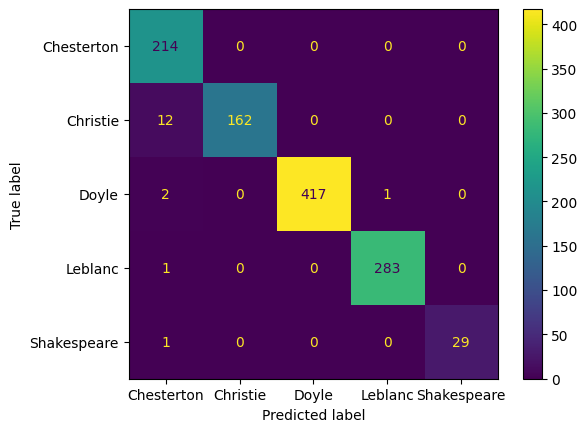

In [16]:
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(classification_report(y_test, pred, target_names=target_encoder.categories_[0]))
ConfusionMatrixDisplay.from_predictions(y_test.argmax(axis=1), pred.argmax(axis=1), display_labels= target_encoder.categories_[0])